# Continental geotherms

This lab exercise examines borehole temperature records from Eastern Canada, published by Pollack and Huang (2000). You can read their Annual Reviews paper here, which contains similar data [Pollack and Huang (2000)](https://www.annualreviews.org/doi/pdf/10.1146/annurev.earth.28.1.339)

Depending on your point of view, the shallow parts of these borehole temperature profiles are either contaminated (in the sense that they don't reflect the geothermal gradient) or contain an interesting signal related to changes in surface temperature. If you remember back to our last lecture, changes in surface temperature require time to propagate into the subsurface.

In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.stats import linregress
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.special import erfc # this syntax can be used to import a single function. You could do e.g. from numpy import pi

# The data is stored in a MATLAB .mat file. We can load it using a routine built in to scipy.
data = loadmat('digitized_temperature_profile.mat')
# data will be a Python dictionary. Dictionaries can contain many different variables, and you can refer to them by name.
# We can find  out what variables are in the dictionary by doing
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'hf_xC', 'hf_ym'])


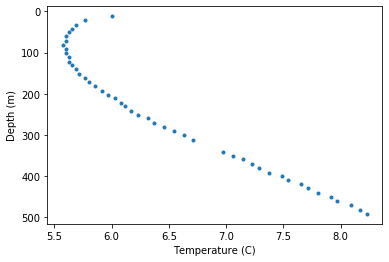

In [2]:
# The above output tells us that there is some header and version information and then two variables.
# hf_xC contains temperatures in degrees centigrade
# hf_ym contains depths in meters
# Let's assign contents to some numpy arrays that we can work with:
temperature_C = data['hf_xC']
depth_m = data['hf_ym']

# Plot the data
# temperature, C vs depth, m
plt.figure()
plt.plot(temperature_C,depth_m,'.')
plt.gca().invert_yaxis()
plt.xlabel('Temperature (C)')
plt.ylabel('Depth (m)')
plt.show()

# Part 1
Fit a line to the linear portion of the data. You can select just the subset of the data correesponding to depths greater than dmin be **slicing** into the arrays. This is done as follows:
```Python
mask = depth_m > 100.0 # this will be True wherever depth > 100.0, False otherwise
# mask will have the same dimensions as depth_m and can be used to select elements 
# from another array for which the mask array contains True
temperature_to_fit = temperature_C[mask]
depth_to_fit = depth_m[mask]
```

You can then fit a straight line to the data using `scipy.stats.linregress`:
[SciPy documentation](https://docs.scipy.org/doc/scipy-1.4.1/reference/generated/scipy.stats.linregress.html?highlight=linreg#scipy.stats.linregress)

Determine the slope and intercept of the best fit to the linear portion of the data.

In [3]:
#  your code here
linear_fit_depth = 250.0 # define a depth to do linear fit
mask = depth_m > linear_fit_depth # this will be True wherever depth > 100.0, False otherwise
# mask will have the same dimensions as depth_m and can be used to select elements 
# from another array for which the mask array contains True
temperature_to_fit = temperature_C[mask]
depth_to_fit = depth_m[mask]
slope, intercept, r_value, p_value, std_err = linregress(depth_to_fit, temperature_to_fit)  # linear fit
print('slope = %.4e [C/m], intercept = %.4e [C]' % (slope, intercept))  # screen output

slope = 8.4441e-03 [C/m], intercept = 4.0954e+00 [C]


# Part 2
Calculate the heat flow, assuming that $k=3.0$ W/m/K (representative of granite). Provide your answer here, and don't forget units. Geophysicists usually measure heat flow in mW/m$^2$.

In [4]:
# your code here
k = 3.0  # conductivity, W/m/K
q = k * slope  # heat flux, q = k * dT/dz, W/m^2
print('Heat flux = %.4e mw/m^2' % (q*1e3))

Heat flux = 2.5332e+01 mw/m^2


# Part 3
The total heat flow from Earth’s surface is around 46 ± 3 TW. Is the heat flow that you calculated representative of the whole Earth? Is it higher or lower than the global average heat flow?

In [5]:
Q = 46e12  # Total heat flow, W
Ro = 6371e3  # Radius of Earth, m
q_avr = Q / (4 * np.pi * Ro**2.0)  # average heat flux W/m^2
print('Average value is %.4e mW/m^2, while the computed value is %.4e mW/m^2' % (q_avr*1e3, q*1e3))

Average value is 9.0185e+01 mW/m^2, while the computed value is 2.5332e+01 mW/m^2


**your response in Markdown...**

Average value is $90.185 mW/m^2$, while the computed value is $21.536 mW/m^2$, it is lower than the global average heat flow.

# Bonus
If time or interest permits, model the shallow part of the temperature profile using either (1) the half-space cooling model or (2) a model of periodic temperature changes. For both cases, you can subtract the linear trend and model only the deviations from a linear profile.

- For (1), you can vary the time (in kya - thousands of years ago) and magnitude of the surface temperature change.
- For (2), you can vary the period, amplitude, and phase of the perturbations.  However, it would be most intuitive to set the location of the last temperature minimum to coincide with the last glacial maximum.

Note that this is a simplistic approach to climate reconstruction but should give you a flavor for the constraints on Pleistocene-Holocene temperature variations offered by borehole temperature measurements. Much of the work being done in this field at present uses Bayesian approaches to quantify the uncertainty in paleotemperature.

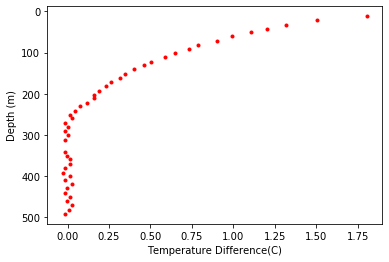

In [6]:
# Plot the temperature difference

temperature_diff = temperature_C - (slope * depth_m + intercept)  # temperature difference
plt.figure()
plt.plot(temperature_diff,depth_m,'r.')
plt.gca().invert_yaxis()
plt.xlabel('Temperature Difference(C)')
plt.ylabel('Depth (m)')
plt.show()

In [7]:
# fit difference temperature by a half space cooling model and a periodic change model
# define the two functions
index_min = np.argmin(temperature_diff)  # get the index for the minimum temperature
mask = range(index_min + 1)  # define the 'shallow' part as above this point of minimux temperaturne
# Vector of T0, T1, t0 to loop for solutions
N0 = 5
N1 = 50  # change this N%d value for computing reason
N2 = 200
T0 = np.linspace(1.2, 2.0, N0)
T1 = np.linspace(temperature_diff[index_min] - 0.5, temperature_diff[index_min], N1)  # take the min temperature as the min difference temperature
t0 = 10.0**(np.linspace(8.0, 12.0, N2))  # take a time to fit, s
seconds_in_year = 3.15e7  # seconds in a year

def TemperatureHalfSpace(_T0, _T1, _t0, _depth_m):
    '''
    Half space cooling temperature
    _T0: surface temperature
    _T1: mantle temperature
    _t0: time
    _depth_m: array, depth
    '''
    _kappa = 1e-6  # diffusivity, m^2/s
    _T = _T1 - (_T1-_T0)*erfc(_depth_m/(2*np.sqrt(_kappa*(_t0))))
    return _T

def TemperaturePeriodicChange(_T0, _dT, _t0, _omega, _depth_m):
    '''
    Periodic change temperature
    _T0: surface temperature
    _dT: variation in temperature
    _omega: angular velocity
    _t0: time
    _depth_m: array, depth in m
    '''
    _kappa = 1e-6  # heat diffusivity, m^2/s
    _T = _T0 + _dT * np.exp(-_depth_m * (_omega / (2*_kappa))**0.5) * np.cos(_omega * _t0 - _depth_m * (_omega / (2*_kappa))**0.5)
    return _T

In [8]:
class FUNC():
    '''Residual functions'''
    def __init__(self, _depth_to_fit, _T_to_fit):
        self.depth_to_fit = _depth_to_fit
        self.T_fit = _T_to_fit
    def HalfSpace(self, _x):
        '''
        Halfspace Cooling Residual
        Inputs:
            _x: an array of nondimentional values of variables
        Outputs:
            residual
        '''
        _T0 = _x[0] * 1.0
        _T1 = _x[1] * 1.0
        _t0 = _x[2] * 1e3 * seconds_in_year  # scale: 1kyr
        return np.linalg.norm(TemperatureHalfSpace(_T0, _T1, _t0, self.depth_to_fit) - self.T_fit, 2.0)
    def PeriodicChange(self, _x):
        """
        Periodic Change Residual
        Inputs:
            _x: an array of nondimentional values of variables
        Outputs:
            residual
        """     
        _T0 = _x[0] * 1.0
        _dT = _x[1] * 1.0
        _t0 = _x[2] * 1e3 * seconds_in_year  # scale: 1kyr
        _omega = _x[3] * 2.0 * np.pi / (1e3 * seconds_in_year)  # scale: 1kyr
        return np.linalg.norm(TemperaturePeriodicChange(_T0, _dT, _t0, _omega, self.depth_to_fit) - self.T_fit, 2.0)
        
Func = FUNC(depth_m, temperature_diff)  # instantiate
x0 = [1.5, 0.0, 1.0]  # fit to half space cooling model
res = minimize(Func.HalfSpace, x0)
T0_fit_hs = res.x[0] * 1.0  # convert to dimensional values
T1_fit_hs = res.x[1] * 1.0
t0_fit_hs = res.x[2] * 1e3 * seconds_in_year
temperature_half_space = TemperatureHalfSpace(T0_fit_hs, T1_fit_hs, t0_fit_hs, depth_m)  # Compute the fit temperature
print("Fit for half space cooling:")
print("T0 = %.4e C, T1 = %.4e C, t0 = %.4e yr" % (T0_fit_hs, T1_fit_hs, (t0_fit_hs/seconds_in_year)))
print("Iter = %d, relative residual %.4e" % (res.nit, res.fun/np.linalg.norm(temperature_diff, 2.0)))

x0 = [1.5, 0.0, 1.0, 1.0]  # fit to Periodic Change model
res = minimize(Func.PeriodicChange, x0)
T0_fit_pc = res.x[0] * 1.0  # convert to dimensional values
dT_fit_pc = res.x[1] * 1.0
t0_fit_pc = res.x[2] * 1e3 * seconds_in_year
omega_fit_pc = res.x[3] * 2.0 * np.pi / (1e3 * seconds_in_year)
period_fit_pc = 2 * np.pi / omega_fit_pc
assert(t0_fit_pc * omega_fit_pc < 2.0 * np.pi)
temperature_periodic_change = TemperaturePeriodicChange(T0_fit_pc, dT_fit_pc, t0_fit_pc, omega_fit_pc, depth_m)  # Compute the fit temperature
print("Fit for Periodic Change:")
print("T0 = %.4e C, DT = %.4e C, t0 = %.4e yr, Peroid = %.4e yr" % (T0_fit_pc, dT_fit_pc, (t0_fit_pc/seconds_in_year), (period_fit_pc/seconds_in_year)))
print("Iter = %d, relative residual %.4e" % (res.nit, res.fun/np.linalg.norm(temperature_diff, 2.0)))


Fit for half space cooling:
T0 = 1.7691e+00 C, T1 = -1.9677e-03 C, t0 = 2.0485e+02 yr
Iter = 14, relative residual 6.8308e-02
Fit for Periodic Change:
T0 = 1.6197e-01 C, DT = 1.8014e+00 C, t0 = 2.8291e+03 yr, Peroid = 3.0535e+03 yr
Iter = 74, relative residual 6.8724e-02


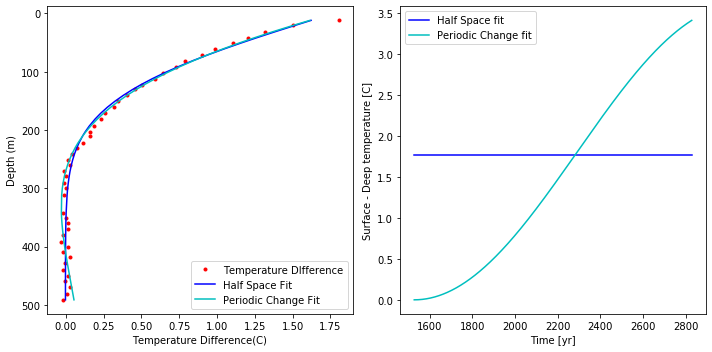

In [9]:
# Plot the temperature and fit
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(temperature_diff,depth_m, 'r.', label='Temperature DIfference')  # plot fit to curve
axs[0].plot(temperature_half_space, depth_m, 'b-', label='Half Space Fit')
axs[0].plot(temperature_periodic_change, depth_m, 'c-', label='Periodic Change Fit')
axs[0].invert_yaxis()
axs[0].set_xlabel('Temperature Difference(C)')
axs[0].set_ylabel('Depth (m)')
axs[0].legend()
tt = np.linspace(period_fit_pc/2.0, t0_fit_pc, 1000)  # plot surface - deep temperature in the last warming phase
dT_hs = (T0_fit_hs - T1_fit_hs) * np.ones((1000, 1))
dT_pc = TemperaturePeriodicChange(0.0, dT_fit_pc, tt, omega_fit_pc, 0.0) + dT_fit_pc  # temperature differece between surface and deep interior
axs[1].plot(tt/seconds_in_year, dT_hs, 'b-', label='Half Space fit')
axs[1].plot(tt/seconds_in_year, dT_pc, 'c', label='Periodic Change fit')
axs[1].set_xlabel('Time [yr]')
axs[1].set_ylabel('Surface - Deep temperature [C]')
axs[1].legend()
fig.tight_layout()
fig.show()

# Results Summary

Fit to half space cooling model shows a ~1.8C temperature difference and an age of 200yr, while fit to periodic change model shows a ~2.0C temperature difference, an age of 2830yr and a period of 3054yr. Relative Residual for both fit is around 0.07. They both have misfit at the first point on top, maybe this could be solved by putting a constraint there. The time difference is worth noticing. The worming phase in the Periodic change model is 2830 - 3054/2 ~= 1300yr, which is 6 times the value from a half space cooling fit. Seeing from the second plot, one possible explanation may be that only during the last portion of this warming phase is the temperature difference between surface and deep interior bigger than the half Space value. Moreover, it has to reset the effects of the cooling phase before.